## Task 3. F-matrix and Relative Pose (4pt)

All the raw pictures needed for this problem are provided in the `data/Task3` folder under the Overleaf project: [https://www.overleaf.com/read/fzhnnqsqrnbz](https://www.overleaf.com/read/fzhnnqsqrnbz). You may or may not need to use all of them in your problem-solving process.

#### a) (2pt)

<b>Estimate</b> the fundamental matrix between `left.jpg` and `right.jpg`.

**Tips:** - The Aruco tags are generated using Aruco’s 6×6 dictionary.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -  You don’t have to use these tags if unnecessary.



<div style="text-align: center; display: flex; justify-content: center; gap: 0;">
  <div style="text-align: center; margin: 0; padding: 0;">
    <img src='left.jpg' width="400" style="margin: 0; padding: 0;">
    <div style="margin: 0; padding: 0;">left.jpg</div>
  </div>
  <div style="text-align: center; margin: 0; padding: 0;">
    <img src='right.jpg' width="386" style="margin: 0; padding: 0;">
    <div style="margin: 0; padding: 0;">right.jpg</div>
  </div>
</div>

---


In [15]:
# Import Necessary Libraries
import numpy as np
from scipy.linalg import svd
import cv2 as cv
import glob
from matplotlib import pyplot as plt

In [16]:
def calibrate_camera(checkerboard_size, criteria, images_path):
    """
    Calibrate the camera using multiple images of a checkerboard pattern.

    Args:
        checkerboard_size (tuple): Number of inner corners per a chessboard row and column (rows, columns).
        criteria (tuple): Termination criteria for corner refinement.
        images_path (str): Path pattern to the calibration images.

    Returns:
        tuple: Camera matrix (K), distortion coefficients (dist), rotation vectors (rvecs), and translation vectors (tvecs).
    """
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane.

    # Prepare object points based on the checkerboard dimensions
    objp = np.zeros((checkerboard_size[0] * checkerboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:checkerboard_size[0],
                           0:checkerboard_size[1]].T.reshape(-1, 2)

    # Retrieve all calibration images
    images = glob.glob(images_path)

    for fname in images:
        img = cv.imread(fname)
        if img is None:
            print(f"Warning: Image {fname} could not be loaded.")
            continue
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(
            gray, checkerboard_size,
            cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE
        )

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(
                gray, corners, winSize=(11, 11),
                zeroZone=(-1, -1), criteria=criteria
            )
            imgpoints.append(corners2)

            # Optionally draw and display the corners
            cv.drawChessboardCorners(img, checkerboard_size, corners2, ret)
            # Uncomment below lines to visualize detected corners
            # cv.imshow('Chessboard Corners', img)
            # cv.waitKey(500)

    # cv.destroyAllWindows()

    if not objpoints or not imgpoints:
        raise ValueError("No checkerboard corners were found in any image.")

    # Perform camera calibration
    ret, K, dist, rvecs, tvecs = cv.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None
    )

    if not ret:
        raise RuntimeError("Camera calibration failed.")

    return K, dist, rvecs, tvecs


In [17]:

def detect_and_match_features(img1_path, img2_path):
    """
    Detect SIFT features in two images and match them using FLANN-based matcher.

    Args:
        img1_path (str): Path to the first image (left image).
        img2_path (str): Path to the second image (right image).

    Returns:
        tuple: Matched keypoints in image1 and image2 as integer NumPy arrays.
    """
    # Load images in grayscale
    img1 = cv.imread(img1_path, cv.IMREAD_GRAYSCALE)
    img2 = cv.imread(img2_path, cv.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        raise FileNotFoundError("One or both images could not be loaded.")

    # Initialize SIFT detector
    sift = cv.SIFT_create()

    # Detect keypoints and compute descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    if des1 is None or des2 is None:
        raise ValueError("No descriptors found in one or both images.")

    # FLANN parameters for SIFT
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # Initialize FLANN-based matcher
    flann = cv.FlannBasedMatcher(index_params, search_params)

    # Perform KNN matching with k=2
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test to filter good matches
    pts1, pts2 = [], []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    if len(pts1) < 8:
        raise ValueError("Not enough matches found for fundamental matrix estimation.")

    # Convert to integer NumPy arrays
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)

    return pts1, pts2, img1, img2

In [18]:
def to_homogeneous(pts):
    """
    Convert 2D points to homogeneous coordinates.

    Args:
        pts (np.ndarray): Array of 2D points.

    Returns:
        np.ndarray: Array of points in homogeneous coordinates.
    """
    ones = np.ones((pts.shape[0], 1))
    return np.hstack([pts, ones])

In [19]:
def normalize_points(pts):
    """
    Normalize 2D points for numerical stability in fundamental matrix estimation.

    Args:
        pts (np.ndarray): Points in homogeneous coordinates.

    Returns:
        tuple: Normalized points and the normalization transformation matrix.
    """
    mean = np.mean(pts[:, :2], axis=0)
    centered = pts[:, :2] - mean
    avg_dist = np.mean(np.sqrt(np.sum(centered**2, axis=1)))
    scale = np.sqrt(2) / avg_dist

    # Transformation matrix: scale and translation
    T = np.array([
        [scale, 0, -scale * mean[0]],
        [0, scale, -scale * mean[1]],
        [0,     0,               1]
    ])

    # Apply transformation
    normalized_pts = (T @ pts.T).T

    return normalized_pts, T

In [20]:
def estimate_fundamental_matrix(p1, p2):
    """
    Estimate the fundamental matrix using the normalized eight-point algorithm.

    Args:
        p1 (np.ndarray): Normalized points from image1 in homogeneous coordinates.
        p2 (np.ndarray): Normalized points from image2 in homogeneous coordinates.

    Returns:
        np.ndarray: Estimated fundamental matrix.
    """
    A = np.zeros((p1.shape[0], 9))
    for i in range(p1.shape[0]):
        u1, v1, _ = p1[i]
        u2, v2, _ = p2[i]
        A[i] = [u1*u2, v1*u2, u2, u1*v2, v1*v2, v2, u1, v1, 1]

    # Perform SVD on A
    _, _, Vt = svd(A)
    F = Vt[-1].reshape(3, 3)

    # Enforce rank-2 constraint
    U, S, Vt = svd(F)
    S[2] = 0  # Set the smallest singular value to zero
    F_rank2 = U @ np.diag(S) @ Vt

    print(f"Determinant of F_rank2: {np.linalg.det(F_rank2):.6f}")
    return F_rank2

In [21]:
def draw_epilines(img1, img2, lines, pts1, pts2):
    """
    Draw epipolar lines on the images corresponding to the points.

    Args:
        img1 (np.ndarray): First image where epilines are drawn.
        img2 (np.ndarray): Second image where corresponding points are marked.
        lines (np.ndarray): Epipolar lines corresponding to points in img2.
        pts1 (np.ndarray): Points in img1.
        pts2 (np.ndarray): Points in img2.

    Returns:
        np.ndarray: Image with epilines and points drawn.
    """
    img1_color = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
    img2_color = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)
    r, c = img1.shape

    for r_line, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r_line[2] / r_line[1]])
        x1, y1 = map(int, [c, -(r_line[2] + r_line[0] * c) / r_line[1]])
        img1_color = cv.line(img1_color, (x0, y0), (x1, y1), color, 1)
        img1_color = cv.circle(img1_color, tuple(pt1), 5, color, -1)
        img2_color = cv.circle(img2_color, tuple(pt2), 5, color, -1)

    return img1_color, img2_color

In [22]:
def compute_essential_matrix(F, K):
    """
    Compute the essential matrix from the fundamental matrix and camera matrix.

    Args:
        F (np.ndarray): Fundamental matrix.
        K (np.ndarray): Camera intrinsic matrix.

    Returns:
        np.ndarray: Essential matrix.
    """
    E = K.T @ F @ K
    print("Essential Matrix:\n", E)
    return E

In [23]:
def decompose_essential_matrix(E):
    """
    Decompose the essential matrix into possible rotation and translation matrices.

    Args:
        E (np.ndarray): Essential matrix.

    Returns:
        tuple: Possible rotation matrices (R1, R2) and translation vector (t).
    """
    U, S, Vt = svd(E)
    
    # Ensure determinant of U and Vt is positive
    if np.linalg.det(U) < 0:
        U *= -1.0
    if np.linalg.det(Vt) < 0:
        Vt *= -1.0

    t = U[:, -1]

    # Define W matrix as per Hartley & Zisserman
    W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]])

    # Possible rotations
    R1 = U @ W @ Vt
    R2 = U @ W.T @ Vt

    # Ensure rotations are proper (determinant = +1)
    if np.linalg.det(R1) < 0:
        R1 *= -1
    if np.linalg.det(R2) < 0:
        R2 *= -1

    print("Possible Rotation Matrices and Translation Vector:")
    print("R1:\n", R1)
    print("\nR2:\n", R2)
    print("\nt:\n", t)

    return R1, R2, t

Calibrating camera...

Camera Matrix:
 [[1.37703227e+03 0.00000000e+00 9.89500107e+02]
 [0.00000000e+00 1.38159326e+03 5.89329411e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
 [[-0.02568162  0.128821    0.00506443  0.00331354 -0.28263947]]

Detecting and matching features...

Estimating Fundamental Matrix...
Determinant of F_rank2: 0.000000

Fundamental Matrix:
 [[-5.15381663e-07 -1.50176439e-06  2.51126170e-03]
 [ 1.84706290e-06 -8.82907296e-07 -4.39793021e-03]
 [-5.83860957e-04  5.36449356e-03 -2.34539228e+00]]

Computing and drawing epipolar lines...


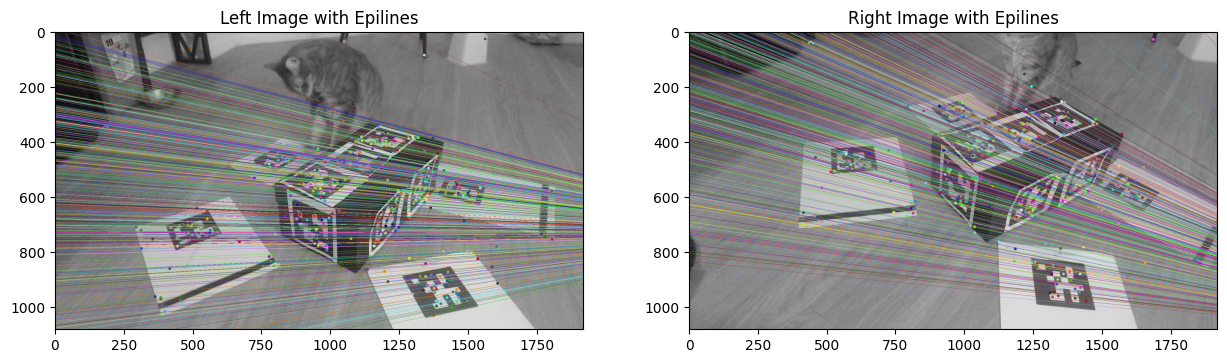


Calculating Essential Matrix...
Essential Matrix:
 [[-0.97727592 -2.85710452  1.53712269]
 [ 3.51403441 -1.6852934  -4.26993075]
 [-0.00730196  4.639631   -0.4785043 ]]

Decomposing Essential Matrix...
Possible Rotation Matrices and Translation Vector:
R1:
 [[ 0.28525388  0.38035434  0.87975042]
 [ 0.05951432 -0.92314465  0.37981838]
 [ 0.95660246 -0.05598692 -0.28596712]]

R2:
 [[ 0.95549827 -0.27728636  0.10067438]
 [ 0.28739648  0.95196216 -0.10569438]
 [-0.06653059  0.12992426  0.98928932]]

t:
 [0.79235751 0.22154092 0.56840936]


In [24]:
def main():
    # === Camera Calibration ===
    CHECKERBOARD = (8, 6)
    CRITERIA = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    IMAGES_PATH = '/home/jithin/Desktop/Perception_HW2/Robot_Perception/HW2/F_matrix_using_Stereo_images//data/*.jpg'


    print("Calibrating camera...")
    K, dist, rvecs, tvecs = calibrate_camera(CHECKERBOARD, CRITERIA, IMAGES_PATH)
    print("\nCamera Matrix:\n", K)
    print("\nDistortion Coefficients:\n", dist)

    # === Feature Detection and Matching ===
    LEFT_IMAGE_PATH = '/home/jithin/Desktop/Perception_HW2/Robot_Perception/HW2/F_matrix_using_Stereo_images/left.jpg'
    RIGHT_IMAGE_PATH = '/home/jithin/Desktop/Perception_HW2/Robot_Perception/HW2/F_matrix_using_Stereo_images/right.jpg'

    print("\nDetecting and matching features...")
    pts1, pts2, img1, img2 = detect_and_match_features(LEFT_IMAGE_PATH, RIGHT_IMAGE_PATH)

    # === Fundamental Matrix Estimation ===
    print("\nEstimating Fundamental Matrix...")
    pt1_homo = to_homogeneous(pts1)
    pt2_homo = to_homogeneous(pts2)

    # Normalize points
    p1_norm, T1 = normalize_points(pt1_homo)
    p2_norm, T2 = normalize_points(pt2_homo)

    # Estimate fundamental matrix using normalized points
    F_normalized = estimate_fundamental_matrix(p1_norm, p2_norm)

    # Denormalize fundamental matrix
    F = T2.T @ F_normalized @ T1
    print("\nFundamental Matrix:\n", F)

    # === Epipolar Lines Visualization ===
    print("\nComputing and drawing epipolar lines...")
    # Compute epilines for points in the second image and draw them on the first image
    lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
    lines1 = lines1.reshape(-1, 3)
    img5, img6 = draw_epilines(img1, img2, lines1, pts1, pts2)

    # Compute epilines for points in the first image and draw them on the second image
    lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)
    img3, img4 = draw_epilines(img2, img1, lines2, pts2, pts1)

    # Display the images with epilines
    plt.figure(figsize=(15, 7))
    plt.subplot(121)
    plt.title('Left Image with Epilines')
    plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
    plt.subplot(122)
    plt.title('Right Image with Epilines')
    plt.imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
    plt.show()

    # === Essential Matrix and Decomposition ===
    print("\nCalculating Essential Matrix...")
    E = compute_essential_matrix(F, K)

    print("\nDecomposing Essential Matrix...")
    R1, R2, t = decompose_essential_matrix(E)

    # The possible configurations are (R1, t), (R1, -t), (R2, t), (R2, -t)
    # Further disambiguation is needed to determine the correct configuration

if __name__ == "__main__":
    main()
